# Apply ARIMA on one measurement such as ODO in one error type(?time series data), get the score


In [1]:
# -*- coding:utf-8 -*-
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import statsmodels.api as api
#import statsmodels.tsa as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import seaborn as sns
from sklearn import metrics


In [75]:
category = "ODO"
corrected_data = pd.read_csv("CorrectedData/LR_Mendon_AA_{0}_SourceID_1_QC_1.csv".format(category), parse_dates=["LocalDateTime"])

In [117]:
year = "2015"
raw_data = pd.read_csv("RawData/LR_Mendon_AA_SourceID_1_QC_0_Year_{0}.csv".format(year), parse_dates=["LocalDateTime"])

In [118]:
print("current dataset {0} {1}".format(category, year))
s_corr =corrected_data[(corrected_data["LocalDateTime"] >= year + "-01-01 00:00:00") & \
    (corrected_data["LocalDateTime"] <= year + "-12-31 23:59:59")]
s_raw = raw_data[["LocalDateTime",category]]

current dataset ODO 2015


In [119]:
s_corr.set_index("LocalDateTime", inplace=True)

In [120]:
s_raw.set_index("LocalDateTime",inplace=True)

In [121]:
s_raw.info(), s_corr.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34754 entries, 2015-01-01 00:00:00 to 2015-12-31 23:45:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ODO     34754 non-null  float64
dtypes: float64(1)
memory usage: 543.0 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35040 entries, 2015-01-01 00:00:00 to 2015-12-31 23:45:00
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   UTCOffset      35040 non-null  float64
 1   DateTimeUTC    35040 non-null  object 
 2   ODO            35040 non-null  float64
 3   CensorCode     35040 non-null  object 
 4   QualifierCode  386 non-null    object 
dtypes: float64(2), object(3)
memory usage: 1.6+ MB


(None, None)

In [122]:
s_join = s_raw.join(s_corr[[category, "QualifierCode"]], on="LocalDateTime", how="outer", lsuffix="_raw")
s_join.reset_index(inplace=True)
if "index" in s_join.columns:
    s_join.drop(columns=["index"], axis=1, inplace=True)
s_join.head()

,LocalDateTime,ODO_raw,ODO,QualifierCode
0,2015-01-01 00:00:00,11.81,11.81,NaN
1,2015-01-01 00:15:00,11.81,11.81,NaN
2,2015-01-01 00:30:00,11.80,11.80,NaN
3,2015-01-01 00:45:00,11.78,11.78,NaN
4,2015-01-01 01:00:00,11.76,11.76,NaN


In [123]:
# s_join.set_index("LocalDateTime", inplace=True)

In [124]:
s_join.head()

,LocalDateTime,ODO_raw,ODO,QualifierCode
0,2015-01-01 00:00:00,11.81,11.81,NaN
1,2015-01-01 00:15:00,11.81,11.81,NaN
2,2015-01-01 00:30:00,11.80,11.80,NaN
3,2015-01-01 00:45:00,11.78,11.78,NaN
4,2015-01-01 01:00:00,11.76,11.76,NaN


In [125]:
s_join.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   LocalDateTime  35040 non-null  datetime64[ns]
 1   ODO_raw        34754 non-null  float64       
 2   ODO            35040 non-null  float64       
 3   QualifierCode  386 non-null    object        
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 1.1+ MB


In [135]:
# s_join["ODO_raw"].fillna()
# type(s_join.index.values)
start_month = 1
end_month = 6
s_month = s_join[(s_join["LocalDateTime"] >= "{0}-{1}-01 00:00:00".format(year, start_month)) & 
                 (s_join["LocalDateTime"] < "{0}-{1}-30 00:00:00".format(year, end_month))]
s_month.head()

,LocalDateTime,ODO_raw,ODO,QualifierCode
0,2015-01-01 00:00:00,11.81,11.81,NaN
1,2015-01-01 00:15:00,11.81,11.81,NaN
2,2015-01-01 00:30:00,11.80,11.80,NaN
3,2015-01-01 00:45:00,11.78,11.78,NaN
4,2015-01-01 01:00:00,11.76,11.76,NaN


In [136]:
anomal = s_month[s_month["QualifierCode"].notnull()]
anomal

,LocalDateTime,ODO_raw,ODO,QualifierCode
531,2015-01-06 12:45:00,11.64,11.730000,LI
532,2015-01-06 13:00:00,11.64,11.810000,LI
533,2015-01-06 13:15:00,11.64,11.890000,LI
534,2015-01-06 13:30:00,11.66,11.970000,LI
1119,2015-01-12 15:45:00,10.91,10.937776,LI
...,...,...,...,...
34761,2015-04-17 14:15:00,NaN,11.025000,LI
34762,2015-04-17 14:30:00,NaN,11.002500,LI
34763,2015-04-17 16:00:00,NaN,10.746667,LI
34764,2015-04-17 16:15:00,NaN,10.673333,LI


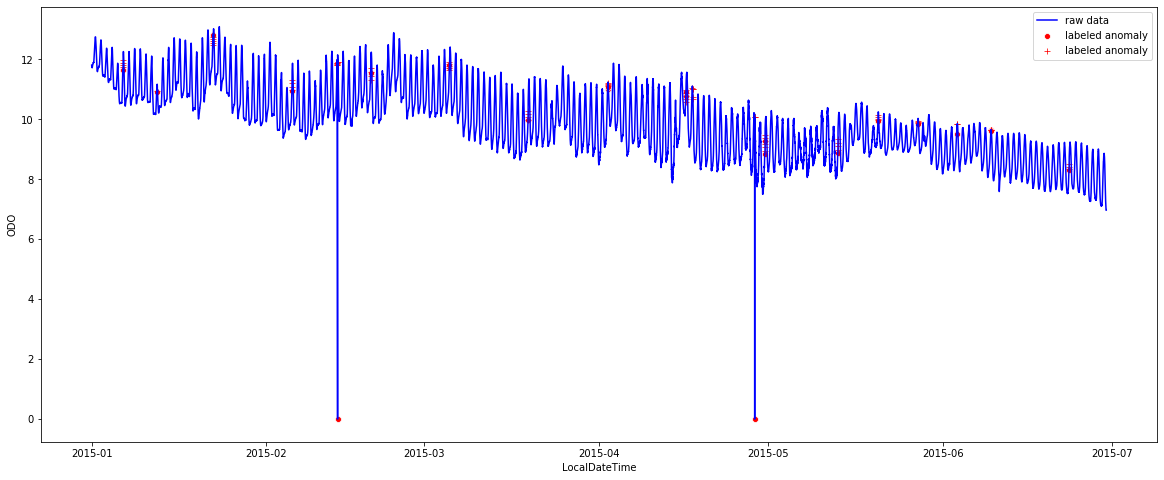

In [138]:
# plot raw data, corrected data, anomal label
fig, axs = plt.subplots(figsize=(20,8))
sns.lineplot(x=s_month["LocalDateTime"], y=s_month["ODO_raw"], label="raw data", color="b")
# sns.lineplot(x=s_month["LocalDateTime"], y=s_month["ODO"], label="corrected data", color="y")
sns.scatterplot(x=anomal["LocalDateTime"], y = anomal["ODO_raw"], label="labeled anomaly", color="r", marker="o")
sns.scatterplot(x=anomal["LocalDateTime"], y = anomal["ODO"], label="labeled anomaly", color="r", marker="+")
plt.show()

In [144]:
# remove nan of odo raw values
s_join_clean = s_join[s_join["ODO_raw"].notnull()]
s_join_clean["resids"] = np.abs(s_join_clean["ODO_raw"] - s_join_clean["ODO"])

/Users/haixuanguo/opt/anaconda3/envs/env2/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [153]:
s_join_clean[s_join_clean["QualifierCode"].isnull()]["resids"]

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
34749    0.0
34750    0.0
34751    0.0
34752    0.0
34753    0.0
Name: resids, Length: 34654, dtype: float64

In [174]:
def random_threshold(labels_true, y_pred, threshold=None):
    ths = np.arange(0,1,0.01)
    fscores = []
    for th in ths:
        labels_pred = [0 if r < th else 1 for r in y_pred]

        f1 = metrics.f1_score(labels_true, labels_pred)
        fscores.append(f1)

    sns.lineplot(ths, fscores)
    plt.xlabel("threshold")
    plt.ylabel("f1-score")
    
    if not threshold:
        threshold = ths[np.argmax(fscores)]
    labels_pred = [0 if r < th else 1 for r in y_pred]
    f1 = metrics.f1_score(labels_true, labels_pred)
    cm = metrics.confusion_matrix(labels_true, labels_pred , labels=[1,0])
    print("best threshold", threshold)
    print("maximum f1-score", f1)
    print("maximum confusion matrix", cm)

In [176]:
def gaussian(x, mu, sig):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

def gaussian_threshold(labels_true, y_pred,  mu=0, sig=1,threshold=None):
    pp = []
    for y in y_pred:
        p = gaussian(y, mu,sig)
        pp.append(pp)
        
    ths = np.arange(0,1,0.01)
    fscores = []
    for th in ths:
        labels_pred = [0 if r < th else 1 for r in pp]

        f1 = metrics.f1_score(labels_true, labels_pred)
        fscores.append(f1)

    sns.lineplot(ths, fscores)
    plt.xlabel("threshold")
    plt.ylabel("f1-score")
    
    if not threshold:
        threshold = ths[np.argmax(fscores)]
    labels_pred = [0 if r < th else 1 for r in y_pred]
    f1 = metrics.f1_score(labels_true, labels_pred)
    cm = metrics.confusion_matrix(labels_true, labels_pred , labels=[1,0])
    print("best threshold", threshold)
    print("maximum f1-score", f1)
    print("maximum confusion matrix", cm)   

best threshold 0.36
maximum f1-score 0.0392156862745098
maximum confusion matrix [[    2    98]
 [    0 34654]]


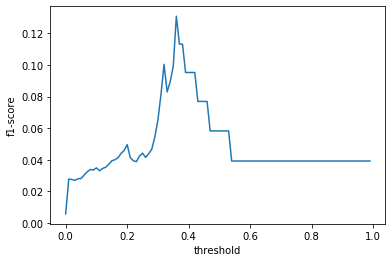

In [175]:
# set threshold by residuals between raw data and corrected data
labels = [ 0 if pd.isnull(s) else 1 for s in s_join_clean["QualifierCode"]]
random_threshold(labels, s_join_clean["resids"])

In [ ]:
normal = s_join_clean[s_join_clean["QualifierCode"].isnull()]["resids"]
mu, sig = np.mean(normal), np.std(normal)
gaussian_threshold(labels, s_join_clean["resids"], mu, sig)

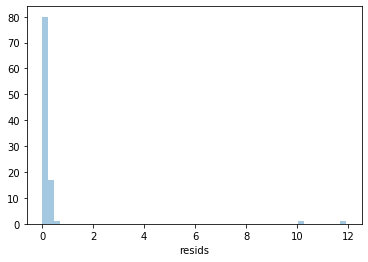

[]

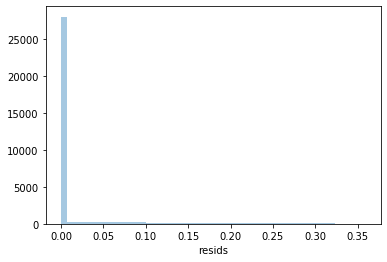

In [156]:
# anomal residuals ditrbution
sns.distplot(s_join_clean[s_join_clean["QualifierCode"].notnull()]["resids"],kde=False) 
plt.show()
# normal residuals ditrbution
sns.distplot(s_join_clean[s_join_clean["QualifierCode"].isnull()]["resids"], kde=False)
plt.plot()

In [113]:
def create_dataset2(X, y, history_size, target_size, time_steps=1):
    Xs, ys = [], []
    start_index = history_size
    end_index = len(X) - target_size
    for i in range(start_index, end_index): # add target_size
        indices = np.arange(i-history_size, i, time_steps)
        Xs.append(X.iloc[indices])
        indices = np.arange(i, i+target_size)
        ys.append(y.iloc[indices])
    return Xs, ys

In [13]:
def create_dataset(X, y, history_size, time_step):
    Xs, ys = [], []
    for i in range(0, len(X)-history_size, time_step): # add target_size
        indices = np.arange(i, i+history_size)
        Xs.append(X.iloc[indices])
        ys.append(y.iloc[indices])
    return Xs, ys

In [14]:
def plot_ts(history, true_future, prediction, time_step):
    plt.figure(figsize=(12, 6))
    num_in = len(history)#list( i * time_step for i in range(-len(history), 0))
    num_out = len(true_future)

    plt.plot(np.arange(num_out), np.array(history), label='raw data') # col=1 is target column
    plt.plot(np.arange(num_out), np.array(true_future), 'g-',
           label='corrected data')

    plt.plot(np.arange(num_out), np.array(prediction), 'r-',
             label='Predicted date')
    plt.legend(loc='upper left')
    plt.show()

In [15]:
# method 1: fitting history window data into arima, then predict future_windows data
# 7 days -> 1 days
# 14 days -> 7days
# probems: every time to tune model, like (p,d,q)

In [16]:
train_split = len(s_join)
p, d, q = 1,0,1

train = s_join[category + "_raw"][:train_split] #raw data
# test = dataset[train_split: train_split + 3000] # 
test = s_join[category][:train_split] #correct data
train_split , train[:5], test[:5]

(30947, LocalDateTime
 2019-01-01 00:00:00    12.96
 2019-01-01 00:15:00    12.97
 2019-01-01 00:30:00    13.01
 2019-01-01 00:45:00    13.03
 2019-01-01 01:00:00    13.08
 Name: ODO_raw, dtype: float64, LocalDateTime
 2019-01-01 00:00:00    11.193762
 2019-01-01 00:15:00    11.203743
 2019-01-01 00:30:00    11.243724
 2019-01-01 00:45:00    11.263705
 2019-01-01 01:00:00    11.313686
 Name: ODO, dtype: float64)

In [17]:
dy = 96 # 1 day = 96 observations
hs = 14*dy # one month
ts = 7*dy # one week
tp = 96 # num of observations

In [18]:
X_train, y_train = create_dataset(train, test, history_size=hs, time_step=hs)

In [19]:
len(X_train), X_train[0].shape, y_train[0].shape

(23, (1344,), (1344,))

In [20]:
y_pred = []
x_raw = []
y_corr = []
resids = []
ll =len(X_train)
for i in range(ll):
    xt = X_train[i]
    arima_model = ARIMA(xt, order=(p,d,q)).fit(disp=0)
    
    yt = y_train[i]
    start_time = xt[0:1].index[0]
    end_time = xt[hs-1:hs].index[0]
    yp = arima_model.predict()
    
    resids += list(arima_model.resid)
    y_pred += list(yp)
    x_raw += list(xt)
    y_corr += list(yt)
#     print("time",start_time, end_time)
 

/Users/haixuanguo/opt/anaconda3/envs/env2/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
/Users/haixuanguo/opt/anaconda3/envs/env2/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
/Users/haixuanguo/opt/anaconda3/envs/env2/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
/Users/haixuanguo/opt/anaconda3/envs/env2/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
/Users/haixuanguo/opt/anaconda3/envs/env2/lib/python3.7/site-packages/statsmodels/base/model.py:

In [361]:
len(y_corr2), len(X_train), len(s_join)

(34944, 26, 35040)

In [362]:
## anomaly classification

In [364]:
labels_true = s_join["QualifierCode"].apply(lambda x: 0 if pd.isna(x) else 1)

In [365]:
ths = np.arange(0,1,0.01)
fscores = []
for i in ths:
    threshold = i
    labels_pred = [1 if np.abs(i) >= threshold else 0 for i in resids]
    f1 = metrics.f1_score(labels_true[:len(y_pred)], labels_pred)
    fscores.append(f1)
    
sns.lineplot(ths, fscores)
plt.xlabel("threshold")
plt.ylabel("f1-score")

threshold = ths[np.argmax(fscores)]
labels_pred = [1 if np.abs(i) >= threshold else 0 for i in resids]
f1 = metrics.f1_score(labels_true[:len(y_pred)], labels_pred)
cm = metrics.confusion_matrix(labels_true[:len(y_pred)], labels_pred , labels=[1,0])
print(f1)
print(cm)

Text(0, 0.5, 'f1-score')

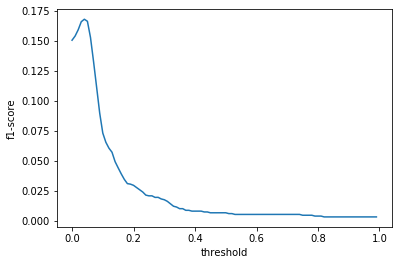

In [369]:
## visualization

In [370]:
y_corr2 = [max(i,0) for i in y_corr]

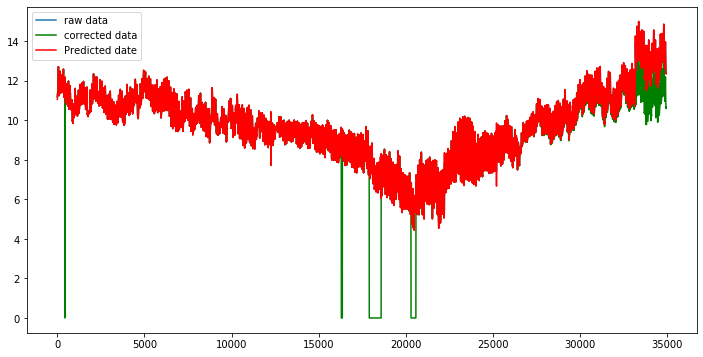

In [371]:
plot_ts(x_raw, y_corr2, y_pred, 1)

In [372]:
resid_corr = [y_corr[i] - y_pred[i] for i in range(len(y_corr)) if y_corr[i] > 0]
np.mean(np.square(np.array(resid_corr)))

0.16402706677407541

In [341]:
################ end 

0.0008474565446870974

In [155]:
dataset.describe()

,ODO_raw,ODO
count,35025.000000,35040.000000
mean,9.830657,7.831515
std,1.107619,141.457654
min,7.720000,-9999.000000
25%,9.040000,9.040000
50%,9.790000,9.790000
75%,10.560000,10.560000
max,13.460000,13.460000


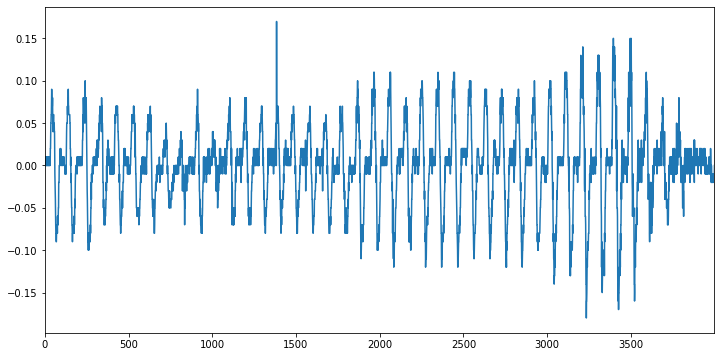

In [128]:
# difference 
diff1 = train["ODO_raw"].diff(1)
diff1.plot(figsize=(12,6))

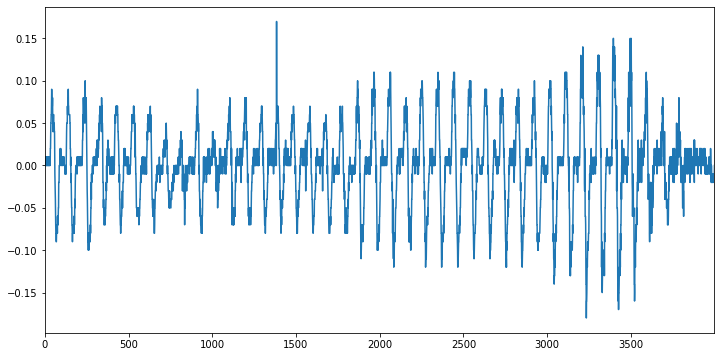

In [129]:
diff2 = train["ODO_raw"].diff(1)
diff2.plot(figsize=(12,6))

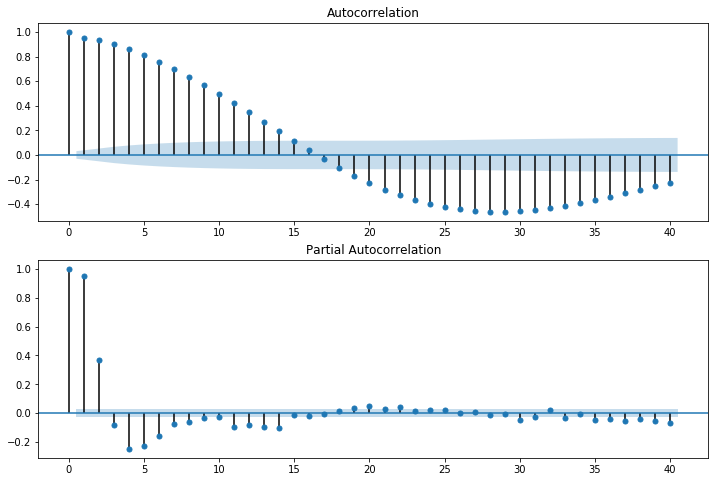

In [131]:
# plot acf and pacf to make sure p,q
diff1.dropna(inplace=True)
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff1,lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff1,lags=40,ax=ax2)

In [149]:
p,d,q = 1,1,3
model = ARIMA(train["ODO"], order=(p,d,q))
model_fit = model.fit(disp=0)

print(model_fit.summary())

/opt/anaconda3/envs/env6830/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


                             ARIMA Model Results                              
Dep. Variable:                  D.ODO   No. Observations:                28031
Model:                 ARIMA(1, 1, 3)   Log Likelihood             -164154.219
Method:                       css-mle   S.D. of innovations             84.540
Date:                Tue, 14 Apr 2020   AIC                         328320.439
Time:                        08:24:27   BIC                         328369.885
Sample:                             1   HQIC                        328336.356
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -5.521e-05      0.505     -0.000      1.000      -0.990       0.990
ar.L1.D.ODO  6.109e-05        nan        nan        nan         nan         nan
ma.L1.D.ODO -6.247e-05        nan        nan    

/opt/anaconda3/envs/env6830/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/opt/anaconda3/envs/env6830/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/anaconda3/envs/env6830/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/anaconda3/envs/env6830/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)




residuals description:
                  0
count  2.803100e+04
mean   6.302488e-07
std    8.454183e+01
min   -1.000855e+04
25%   -1.994511e-02
50%    5.530351e-05
75%    2.005535e-02
max    1.000841e+04


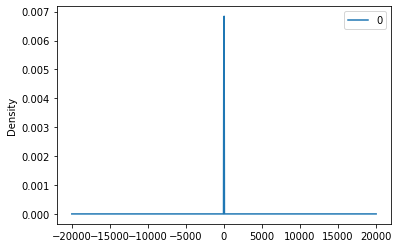

In [150]:
residuals = pd.DataFrame(model_fit.resid)
print('\n\nresiduals description:')
print(residuals.describe())

residuals.plot(kind="kde")

In [151]:
p,d,q = 1,1,1
model = ARIMA(train["ODO"], order=(p,d,q))
model_fit = model.fit(disp=0)

print(model_fit.summary())

residuals = pd.DataFrame(model_fit.resid)
print('\n\nresiduals description:')
print(residuals.describe())


/opt/anaconda3/envs/env6830/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


                             ARIMA Model Results                              
Dep. Variable:                  D.ODO   No. Observations:                28031
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -164154.219
Method:                       css-mle   S.D. of innovations             84.540
Date:                Tue, 14 Apr 2020   AIC                         328316.439
Time:                        08:25:21   BIC                         328349.403
Sample:                             1   HQIC                        328327.050
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -5.323e-05      0.505     -0.000      1.000      -0.990       0.990
ar.L1.D.ODO  6.119e-05        nan        nan        nan         nan         nan
ma.L1.D.ODO -6.237e-05        nan        nan    

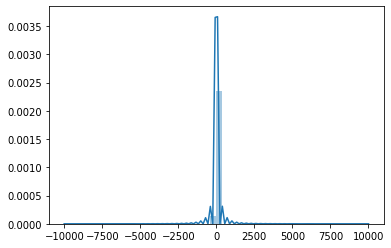

In [152]:
sns.distplot(residuals)